In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings, copy, time, glob
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from helpers import *
from utilities import *
from model import *
from train import train_all_single_policies
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)
models_path = './models/' 

C:\Users\sshi\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load raw data

In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(3)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Get some suplementary data

In [3]:
# # its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order
# # ddentify defending and offending runs (this is included in process_moments)
# court_index = Data.load_csv('./meta_data/court_index.csv')
# court_index = dict(zip(court_index.game_id, court_index.court_position))

# # home and visitor ids
# homeid = events_df.loc[0].home['teamid']
# awayid = events_df.loc[0].visitor['teamid']

#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [13]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
# use_event = [1, 2, 4, 6, 7]
# discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
# events = filter_event_type(events_df, discard_event)
# events = events_df.copy()
# print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
event_threshold = 50
subsample_factor = 2
single_game, single_game_balls, ohes = process_game_data(game_id, events_df, event_threshold, subsample_factor)

print('Final number of events:', len(single_game))

[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]


[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612741, 1610612761]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
[1610612761, 1610612741]
subsample enabled with subsample factor 2
Final number of events: 368


In [14]:
# get player velocity
fs_base = 1./25 # 1/25 sec/frame   or  25 frames/sec
fs = fs_base * subsample_factor if subsample_factor != 0 else fs_base
single_game = [get_velocity(i, fs, mode=1) for i in single_game]
n_events = len(single_game)

# get basketball velocity
single_game_balls = [np.concatenate([i[:-1, :], get_velocity(i, fs, mode=0)], axis=1) for i in single_game_balls]

In [15]:
len(single_game)

368

In [16]:
single_game_balls[0].shape

(164, 6)

#### Role assignment and reorder moment

In [17]:
# first prepare data
n_defend = 5
n_offend = 5
n_ind = 4

# length for each moment
event_lengths = np.array([len(i) for i in single_game])
# repeat the event_lengths 5 times in order to match the unstack later on with moments
event_lengths_repeat = np.concatenate([event_lengths for _ in range(n_defend)], axis=0)
# all the moments
all_moments = np.concatenate(single_game, axis=0)
all_moments_vel = np.concatenate(single_game, axis=0) # vel
# we only need the first 5 players x,y coordindates
# defend
all_defend_moments = all_moments[:, :n_ind*n_defend]
# offend
all_offend_moments = all_moments[:, n_ind*n_offend:]

# flattened
all_defend_moments_ = np.concatenate([all_defend_moments[:, i:i+n_ind] for i in range(0, n_ind*n_defend, n_ind)], axis=0)
all_offend_moments_ = np.concatenate([all_offend_moments[:, i:i+n_ind] for i in range(0, n_ind*n_offend, n_ind)], axis=0)

In [18]:
# create hmm model
n_comp = 5
n_mix = None
RA = RoleAssignment(n_iter=50,verbose=True)

In [19]:
# train
defend_state_sequence_, defend_means, defend_covs, _ = RA.train_hmm(all_defend_moments_, event_lengths_repeat, n_comp, n_mix)
offend_state_sequence_, offend_means, offend_covs, _ = RA.train_hmm(all_offend_moments_, event_lengths_repeat, n_comp, n_mix)
# get role orders
_, defend_roles = RA.assign_roles(all_defend_moments_, all_defend_moments, defend_means, event_lengths)
_, offend_roles = RA.assign_roles(all_offend_moments_, all_offend_moments, offend_means, event_lengths)

         1    -1826674.4044             +nan
         2    -1686692.6638     +139981.7406
         3    -1581640.9931     +105051.6707
         4    -1545529.0201      +36111.9731
         5    -1528093.9220      +17435.0981
         6    -1522984.7918       +5109.1302
         7    -1521051.9357       +1932.8561
         8    -1519875.2619       +1176.6738
         9    -1519038.4413        +836.8206
        10    -1518430.6125        +607.8288
        11    -1517867.9870        +562.6256
        12    -1517232.3533        +635.6336
        13    -1516611.6591        +620.6942
        14    -1516085.2894        +526.3697
        15    -1515605.5084        +479.7810
        16    -1515154.5973        +450.9112
        17    -1514849.3621        +305.2351
        18    -1514659.2799        +190.0822
        19    -1514561.7972         +97.4827
        20    -1514509.0675         +52.7298
        21    -1514473.0346         +36.0329
        22    -1514445.1851         +27.8495
        23

In [20]:
defend_pos_vel = order_moment_ra([i[:, :n_ind*5] for i in single_game], defend_roles, components=n_comp)
offend_pos_vel = order_moment_ra([i[:, n_ind*5:] for i in single_game], offend_roles, components=n_comp)

In [21]:
ohes_ = [np.tile(ohes[i], (len(single_game_balls[i]), 1)) for i in range(n_events)]
# concatenate defend, offend roles pos and velocity and the basketball pos and vel
single_game = [np.concatenate([defend_pos_vel[i], offend_pos_vel[i], single_game_balls[i], ohes_[i]], axis=1) for i in range(n_events)]

#### Show the plot, for the sake of comparison with processed moment later on

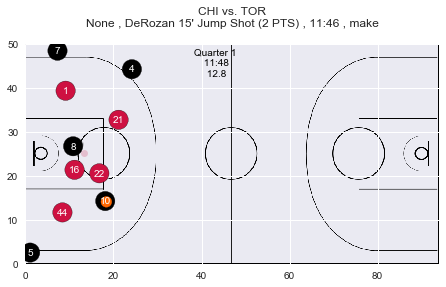

In [22]:
Plot = PlotGame(game_id, main_dir, game_dir)
# for i in range(plotn): 
Plot.load_moment2img(game_data, event_number=0, moment_number=0, return_img=True)

In [23]:
single_game[0].shape

(164, 50)

In [ ]:
plt_ind = 0

In [ ]:
single_game[46]

In [ ]:
single_game[0].shape

In [ ]:
# manual plot check
print(plt_ind)
plot_check(single_game, plt_ind)
plt_ind += 1

#### Build graph and starts training for all single policies

In [ ]:
sequence_length = 25
overlap = 10
batch_size = 32
train_all_single_policies(single_game, batch_size, sequence_length, overlap, models_path)

### Check performance

In [ ]:
# pad short sequence and chunk long sequence with overlaps
policy = 0
train, target = get_sequences(single_game, policy, sequence_length, overlap)
# create train and test set
p = 0.8 # train percentage
divider = int(len(train)*p)
train_game, test_game = np.copy(train[:divider]), np.copy(train[divider:])
train_target, test_target = np.copy(target[:divider]), np.copy(target[divider:])
Model = ImportGraph('policy0/')

In [ ]:
n = 0

In [ ]:
# manual plot check
plot_check(train_game, n)
n+=1

In [ ]:
# use while loop to make sure the 
train_batches = get_minibatches(train_game, train_target, batch_size, shuffle=False)

check_ind = np.random.randint(0, len(train_game)//batch_size)
print('rand checking index: {0:} out of {1:}'.format(check_ind, len(train_game)//batch_size))

input_xi, output_yi = train_batches

y_pred = Model.forward_pass(input_xi[check_ind], h=1)
y_true = output_yi[check_ind]
    
y_pred = y_pred[0][0].reshape(-1,2)
y_true = y_true[0].reshape(-1,2)

plt.figure(figsize=(15,8))
for k in range(0, len(y_pred)):
    plt.plot(y_pred[:, 0][k], y_pred[:, 1][k], linestyle="None", marker="o", markersize=k/3, color='g')
    plt.plot(y_true[:, 0][k], y_true[:, 1][k], linestyle="None", marker="o", markersize=k/3, color='b')

plt.plot(y_pred[:, 0], y_pred[:, 1],'g', y_true[:,0], y_true[:,1], 'b')#, pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning
    - from each sample to next sample theres not much change, subsample them 

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 